## Problem Statement

This tutorial takes a practical and coding-focused approach. We'll learn gradient boosting by applying it to a real-world dataset from the Rossmann Store Sales competition on Kaggle:

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality.

With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

View and download the data here: https://www.kaggle.com/c/rossmann-store-sales/data



## Files

    train.csv - historical data including Sales
    test.csv - historical data excluding Sales
    sample_submission.csv - a sample submission file in the correct format
    store.csv - supplemental information about the stores

## Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

    Id - an Id that represents a (Store, Date) duple within the test set
    Store - a unique Id for each store
    Sales - the turnover for any given day (this is what you are predicting)
    Customers - the number of customers on a given day
    Open - an indicator for whether the store was open: 0 = closed, 1 = open
    StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
    SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
    StoreType - differentiates between 4 different store models: a, b, c, d
    Assortment - describes an assortment level: a = basic, b = extra, c = extended
    CompetitionDistance - distance in meters to the nearest competitor store
    CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
    Promo - indicates whether a store is running a promo on that day
    Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
    Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
    PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
store_data = pd.read_csv("store.csv")

c:\Users\Neelam\Desktop\Desktop\Python\Video\env\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [10]:
store_data.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
# Here, we would like to merge the info we have about store with actual training and test data

merged_train_data = train_data.merge(store_data, how='left', on='Store')

In [6]:
merged_train_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [7]:
merged_test_data = test_data.merge(store_data, how='left', on='Store')

In [8]:
merged_test_data.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,3,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,4,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,5,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


In [9]:
    merged_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 18 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   StoreType                  1017209 non-null  object 
 10  Assortment                 1017209 non-null  object 
 11  CompetitionDistance        1014567 non-null  float64
 12  CompetitionOpenSinceMonth  693861 non-null   float64
 13  CompetitionO

In [10]:

for cols in merged_train_data.columns:
    print(cols, merged_train_data[cols].nunique())

Store 1115
DayOfWeek 7
Date 942
Sales 21734
Customers 4086
Open 2
Promo 2
StateHoliday 5
SchoolHoliday 2
StoreType 4
Assortment 3
CompetitionDistance 654
CompetitionOpenSinceMonth 12
CompetitionOpenSinceYear 23
Promo2 2
Promo2SinceWeek 24
Promo2SinceYear 7
PromoInterval 3


In [11]:
merged_train_data.StoreType.value_counts()

a    551627
d    312912
c    136840
b     15830
Name: StoreType, dtype: int64

## <b>Feature Engineering</b>

In [12]:
# Create a function to call out splitting of date into new columns

def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['WeekofYear'] = df.Date.dt.isocalendar().week

In [13]:
split_date(merged_train_data)

In [14]:
merged_train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekofYear
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31


In [15]:
split_date(merged_test_data)

In [16]:
# Checking all the values of Sales when Open = 0
merged_train_data[merged_train_data.Open == 0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

So, as we can see that whenever store Open=0, we get no sales. So, lets hardcode this in training data so that algorithm can focus on more important/complex relationships. 
For training data, we can simply remove these rows

In [17]:
merged_train_data_2 = merged_train_data[merged_train_data.Open==1].copy()

In [18]:
merged_train_data.shape, merged_train_data_2.shape

((1017209, 22), (844392, 22))

In [59]:
# Checking if we removed correct rows
1017209 - 844392

172817

In [19]:
merged_train_data = merged_train_data[merged_train_data.Open==1].copy()

In [20]:
merged_train_data.shape, merged_train_data_2.shape

((844392, 22), (844392, 22))

In [21]:
# Code to view all the columns while calling .head()
pd.set_option("display.max_columns", None)

In [22]:
def comp_open(df):
    df['CompetitionOpen'] = 12*(df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df['CompetitionOpen'] = df['CompetitionOpen'].map(lambda x: 0 if x<0 else x).fillna(0)

In [23]:
comp_open(merged_train_data)
comp_open(merged_test_data)

In [24]:
merged_train_data[(merged_train_data.CompetitionOpen) < 0]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekofYear,CompetitionOpen


In [25]:
# Copy pasted the code
def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    # Months since Promo2 was open
    df['Promo2Open'] = 12 * (df.Year - df.Promo2SinceYear) +  (df.WeekofYear - df.Promo2SinceWeek)*7/30.5
    df['Promo2Open'] = df['Promo2Open'].map(lambda x: 0 if x < 0 else x).fillna(0) * df['Promo2']
    # Whether a new round of promotions was started in the current month
    df['IsPromo2Month'] = df.apply(check_promo_month, axis=1) * df['Promo2']

In [26]:
promo_cols(merged_train_data)
promo_cols(merged_test_data)

In [27]:
merged_train_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day',
       'WeekofYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month'],
      dtype='object')

In [28]:
'''
Here, we will taking only those columns in input colums to predict target which are relevant.
We will remove columns that are not needed. Thats because, they might interfear with the model
building process.
So, remove "Customers" column as it is not present in training data.
Remove "Date" as now we have infor about Year, Month, Day and WeekofYear

'''

input_cols = ['Store', 'DayOfWeek', 'Promo', 'StateHoliday', 'SchoolHoliday', 
              'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
              'Day', 'Month', 'Year', 'WeekofYear',  'Promo2', 
              'Promo2Open', 'IsPromo2Month']
target_col = 'Sales'


In [29]:
inputs = merged_train_data[input_cols].copy()
targets = merged_train_data[target_col].copy()

test_inputs = merged_test_data[input_cols].copy()


In [30]:
# They both should have same number of columns. Else, training the model will not be efficient
test_inputs.shape, inputs.shape

((41088, 16), (844392, 16))

In [31]:
# Identify categorical or numeric columns. Wether to set Day, Month and Year as numeric or categorical is subjective.
numeric_cols = ['Store', 'Promo', 'SchoolHoliday', 
              'CompetitionDistance', 'CompetitionOpen', 'Promo2', 'Promo2Open', 'IsPromo2Month',
              'Day', 'Month', 'Year', 'WeekofYear',  ]
categorical_cols = ['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']


### Impute Missing Values

In [32]:
inputs[numeric_cols].isna().sum()

Store                     0
Promo                     0
SchoolHoliday             0
CompetitionDistance    2186
CompetitionOpen           0
Promo2                    0
Promo2Open                0
IsPromo2Month             0
Day                       0
Month                     0
Year                      0
WeekofYear                0
dtype: int64

In [33]:
test_inputs[numeric_cols].isna().sum()

Store                   0
Promo                   0
SchoolHoliday           0
CompetitionDistance    96
CompetitionOpen         0
Promo2                  0
Promo2Open              0
IsPromo2Month           0
Day                     0
Month                   0
Year                    0
WeekofYear              0
dtype: int64

The only missing values are in CompetitionDistance. It can be because there are no competing stores nearby.
We don't want to fill this value with 0 as it would mean that competition is just next door. We want to fill it with highest value possible.   

In [34]:
max_distance_competition = inputs.CompetitionDistance.max()
max_distance_competition

75860.0

In [35]:
inputs.CompetitionDistance.fillna(max_distance_competition*2, inplace=True)
test_inputs.CompetitionDistance.fillna(max_distance_competition*2, inplace=True)


In [36]:
inputs[numeric_cols].isna().sum()

Store                  0
Promo                  0
SchoolHoliday          0
CompetitionDistance    0
CompetitionOpen        0
Promo2                 0
Promo2Open             0
IsPromo2Month          0
Day                    0
Month                  0
Year                   0
WeekofYear             0
dtype: int64

### Scale Numeric Values

In [37]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
scalar = MinMaxScaler()
scalar.fit(inputs[numeric_cols])

MinMaxScaler()

In [39]:
inputs[numeric_cols]

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekofYear
0,1,1,1,1270.0,82.0,0,0.000000,0,31,7,2015,31
1,2,1,1,570.0,92.0,1,64.131148,1,31,7,2015,31
2,3,1,1,14130.0,103.0,1,51.901639,1,31,7,2015,31
3,4,1,1,620.0,70.0,0,0.000000,0,31,7,2015,31
4,5,1,1,29910.0,3.0,0,0.000000,0,31,7,2015,31
...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,0,1,150.0,76.0,0,0.000000,0,1,1,2013,1
1016827,733,0,1,860.0,159.0,0,0.000000,0,1,1,2013,1
1016863,769,0,1,840.0,0.0,1,1.213115,1,1,1,2013,1
1017042,948,0,1,1430.0,0.0,0,0.000000,0,1,1,2013,1


In [40]:
test_inputs[numeric_cols]

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekofYear
0,1,1,0,1270.0,84.0,0,0.000000,0,17,9,2015,38
1,3,1,0,14130.0,105.0,1,53.508197,0,17,9,2015,38
2,7,1,0,24000.0,29.0,0,0.000000,0,17,9,2015,38
3,8,1,0,7520.0,11.0,0,0.000000,0,17,9,2015,38
4,9,1,0,2030.0,181.0,0,0.000000,0,17,9,2015,38
...,...,...,...,...,...,...,...,...,...,...,...,...
41083,1111,0,0,1900.0,14.0,1,24.000000,0,1,8,2015,31
41084,1112,0,0,1880.0,112.0,0,0.000000,0,1,8,2015,31
41085,1113,0,0,9260.0,0.0,0,0.000000,0,1,8,2015,31
41086,1114,0,0,870.0,0.0,0,0.000000,0,1,8,2015,31


In [41]:
inputs[numeric_cols] = scalar.transform(inputs[numeric_cols])
test_inputs[numeric_cols] = scalar.transform(test_inputs[numeric_cols])


In [42]:
# Min value should be 0 and max value should be 1
inputs[numeric_cols].describe()

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekofYear
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,0.500380,0.446352,0.193580,0.038343,0.030270,0.498684,0.181163,0.148902,0.494523,0.440522,0.415969,0.444055
std,0.288808,0.497114,0.395103,0.071018,0.047034,0.499999,0.263713,0.355992,0.289449,0.302176,0.388630,0.282153
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250449,0.000000,0.000000,0.004548,0.000000,0.000000,0.000000,0.000000,0.233333,0.181818,0.000000,0.196078
50%,0.500000,0.000000,0.000000,0.015227,0.011544,0.000000,0.000000,0.000000,0.500000,0.454545,0.500000,0.431373
75%,0.750449,1.000000,0.000000,0.045419,0.052670,1.000000,0.346084,0.000000,0.733333,0.636364,0.500000,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [43]:
test_inputs[numeric_cols].describe()

,Store,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpen,Promo2,Promo2Open,IsPromo2Month,Day,Month,Year,WeekofYear
count,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.000000,41088.0,41088.000000
mean,0.498114,0.395833,0.443487,0.035670,0.035262,0.580607,0.326546,0.127434,0.417361,0.668561,1.0,0.659722
std,0.287500,0.489035,0.496802,0.066642,0.054313,0.493466,0.348285,0.333462,0.281615,0.043479,0.0,0.039519
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.636364,1.0,0.588235
25%,0.250224,0.000000,0.000000,0.004614,0.000000,0.000000,0.000000,0.000000,0.191667,0.636364,1.0,0.627451
50%,0.495961,0.000000,0.000000,0.016018,0.020202,1.000000,0.236794,0.000000,0.383333,0.636364,1.0,0.666667
75%,0.746185,1.000000,1.000000,0.042980,0.059885,1.000000,0.641166,0.000000,0.608333,0.727273,1.0,0.686275
max,1.000000,1.000000,1.000000,1.000000,1.001443,1.000000,1.022313,1.000000,1.000000,0.727273,1.0,0.725490


### Encode Categorical Data

In [44]:
from sklearn.preprocessing import OneHotEncoder

In [45]:
categorical_cols

['DayOfWeek', 'StateHoliday', 'StoreType', 'Assortment']

In [46]:
# StateHoliday was throwing error while we were trying to 1 hot encode it. On further inspection,
# we noticed that it had 0 repeated twice, one as numeric value and one as int.
inputs.StateHoliday.value_counts()

0    731342
0    112140
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [47]:
# Converting all numeric 0 to string '0'
inputs.StateHoliday = inputs.StateHoliday.map(lambda x: '0' if x == 0 else x)


In [48]:
inputs.StateHoliday.value_counts()

0    843482
a       694
b       145
c        71
Name: StateHoliday, dtype: int64

In [49]:
test_inputs.StateHoliday.value_counts()

0    40908
a      180
Name: StateHoliday, dtype: int64

In [50]:
onehotencode = OneHotEncoder(sparse=False, handle_unknown='ignore')

onehotencode.fit(inputs[categorical_cols])

#onehotencode.fit(inputs[categorical_cols])
#encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs[categorical_cols])


OneHotEncoder(handle_unknown='ignore', sparse=False)

In [51]:
encoded_cols = list(onehotencode.get_feature_names(categorical_cols))
encoded_cols


['DayOfWeek_1',
 'DayOfWeek_2',
 'DayOfWeek_3',
 'DayOfWeek_4',
 'DayOfWeek_5',
 'DayOfWeek_6',
 'DayOfWeek_7',
 'StateHoliday_0',
 'StateHoliday_a',
 'StateHoliday_b',
 'StateHoliday_c',
 'StoreType_a',
 'StoreType_b',
 'StoreType_c',
 'StoreType_d',
 'Assortment_a',
 'Assortment_b',
 'Assortment_c']

In [52]:
inputs[encoded_cols] = onehotencode.transform(inputs[categorical_cols])

In [53]:
inputs.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekofYear,Promo2,Promo2Open,IsPromo2Month,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,5,1.0,0,1.0,c,a,0.008240,0.059163,1.0,0.545455,1.0,0.588235,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.000898,5,1.0,0,1.0,a,a,0.003626,0.066378,1.0,0.545455,1.0,0.588235,1.0,0.890710,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.001795,5,1.0,0,1.0,a,a,0.093013,0.074315,1.0,0.545455,1.0,0.588235,1.0,0.720856,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.002693,5,1.0,0,1.0,c,c,0.003955,0.050505,1.0,0.545455,1.0,0.588235,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.003591,5,1.0,0,1.0,a,a,0.197034,0.002165,1.0,0.545455,1.0,0.588235,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [54]:
test_inputs[encoded_cols] = onehotencode.transform(test_inputs[categorical_cols])

In [55]:
test_inputs.head()

,Store,DayOfWeek,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpen,Day,Month,Year,WeekofYear,Promo2,Promo2Open,IsPromo2Month,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,DayOfWeek_7,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,0.000000,4,1.0,0,0.0,c,a,0.008240,0.060606,0.533333,0.727273,1.0,0.72549,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.001795,4,1.0,0,0.0,a,a,0.093013,0.075758,0.533333,0.727273,1.0,0.72549,1.0,0.743169,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.005386,4,1.0,0,0.0,a,c,0.158075,0.020924,0.533333,0.727273,1.0,0.72549,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.006284,4,1.0,0,0.0,a,a,0.049440,0.007937,0.533333,0.727273,1.0,0.72549,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.007181,4,1.0,0,0.0,a,c,0.013250,0.130592,0.533333,0.727273,1.0,0.72549,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Now, for the modelling part, we can remove the categorical columns we have used for onehot encoding. So, all we need now is numeric_cols and encoded_cols

In [56]:
X = inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

We haven't created a validation set yet, because we'll use K-fold cross validation.

# Gradient Boosting

We're now ready to train our gradient boosting machine (GBM) model. Here's how a GBM model works:

    - The average value of the target column and uses as an initial prediction every input.
    - The residuals (difference) of the predictions with the targets are computed.
    - A decision tree of limited depth is trained to predict just the residuals for each input.
    - Predictions from the decision tree are scaled using a parameter called the learning rate (this prevents overfitting)
    - Scaled predictions fro the tree are added to the previous predictions to obtain the new and improved predictions.
    - Steps 2 to 5 are repeated to create new decision trees, each of which is trained to predict just the residuals from the previous prediction.

The term "gradient" refers to the fact that each decision tree is trained with the purpose of reducing the loss from the previous iteration (similar to gradient descent). The term "boosting" refers the general technique of training new models to improve the results of an existing model.



## <b>Training</b>

In [57]:
from xgboost import XGBRegressor

In [ ]:
?XGBRegressor

In [58]:
model = XGBRegressor(random_state=42, n_jobs=-1, n_estimators=20, max_depth=4)

In [59]:
# Train the model with model.fit

model.fit(X, targets)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [60]:
pred = model.predict(X)

In [61]:
pred

array([ 8127.9404,  7606.919 ,  8525.857 , ...,  6412.8247,  9460.068 ,
       10302.145 ], dtype=float32)

In [62]:
from sklearn.metrics import mean_squared_error

In [63]:
def rmse(a,b):
    return mean_squared_error(a, b,squared=False)

'''
squared : boolean value, optional (default = True)
    If True returns MSE value, if False returns RMSE value.
'''

'\nsquared : boolean value, optional (default = True)\n    If True returns MSE value, if False returns RMSE value.\n'

In [64]:
rmse(pred, targets)

2377.752008804669

This means that our predictions are off by 2377.

In [65]:
merged_train_data.Sales.min(), merged_train_data.Sales.max()

(0, 41551)

(array([ 87., 354., 309., 155.,  55.,  22.,  11.,   1.,   5.,   1.]),
 array([ 1175. ,  3624.6,  6074.2,  8523.8, 10973.4, 13423. , 15872.6,
        18322.2, 20771.8, 23221.4, 25671. ]),
 <BarContainer object of 10 artists>)

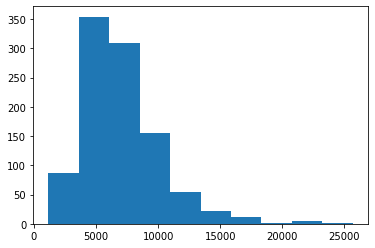

In [67]:
plt.hist(merged_train_data.Sales.sample(1000))

## Visualization
We can visualize individual trees using plot_tree (note: this requires the graphviz library to be installed).



In [85]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Neelam\Desktop\Desktop\Python\Video\env\Scripts\python.exe -m pip install --upgrade pip' command.


In [69]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

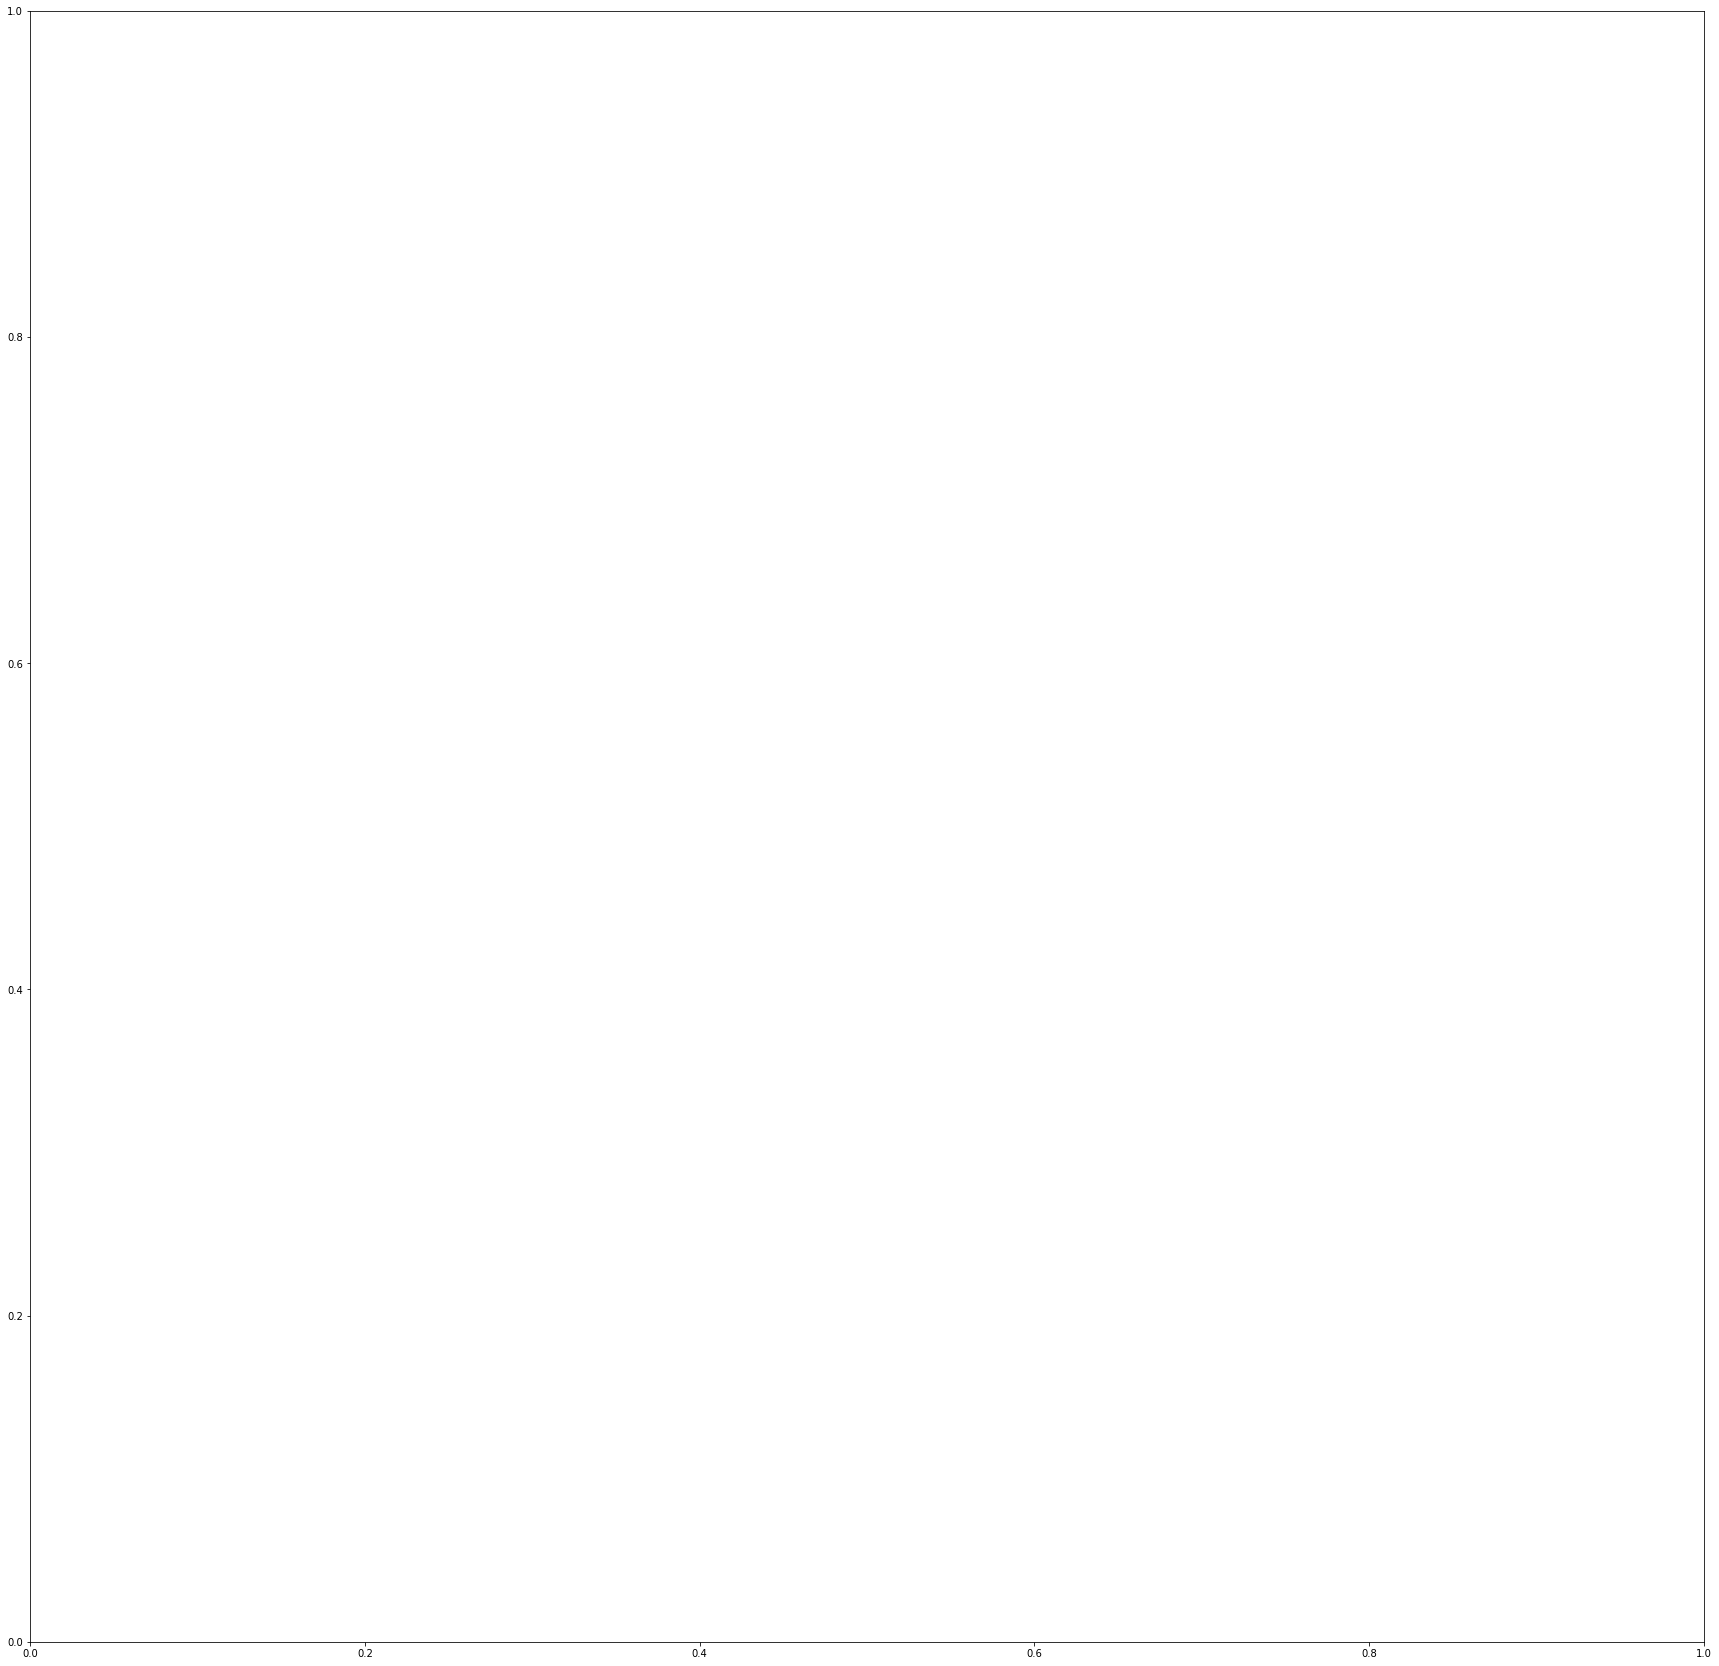

In [86]:
rcParams['figure.figsize'] = 30,30
plot_tree(model, rankdir='LR', num_trees=0)


In [87]:
trees = model.get_booster().get_dump()


In [88]:
len(trees)


20

In [89]:
print(trees[0])


0:[Promo<0.5] yes=1,no=2,missing=1
	1:[StoreType_b<0.5] yes=3,no=4,missing=3
		3:[Assortment_a<0.5] yes=7,no=8,missing=7
			7:[CompetitionDistance<0.00220830599] yes=15,no=16,missing=15
				15:leaf=2309.51147
				16:leaf=1823.30444
			8:[WeekofYear<0.911764741] yes=17,no=18,missing=17
				17:leaf=1619.43994
				18:leaf=2002.44897
		4:[CompetitionDistance<0.00800922886] yes=9,no=10,missing=9
			9:[CompetitionDistance<0.00672379695] yes=19,no=20,missing=19
				19:leaf=2740.44067
				20:leaf=5576.85889
			10:[DayOfWeek_7<0.5] yes=21,no=22,missing=21
				21:leaf=1898.36487
				22:leaf=2961.08765
	2:[DayOfWeek_1<0.5] yes=5,no=6,missing=5
		5:[Month<0.954545498] yes=11,no=12,missing=11
			11:[StoreType_b<0.5] yes=23,no=24,missing=23
				23:leaf=2295.30566
				24:leaf=3294.27759
			12:[Day<0.333333343] yes=25,no=26,missing=25
				25:leaf=2754.58521
				26:leaf=3246.39014
		6:[Month<0.954545498] yes=13,no=14,missing=13
			13:[CompetitionDistance<0.00135135138] yes=27,no=28,missing=27
				27:le

## Feature Importance

In [90]:
#feature_importances_
importance_df = pd.DataFrame({
    "Features": X.columns,
    "Importance": model.feature_importances_
}).sort_values("Importance", ascending=False)

In [92]:
importance_df.head(10)

,Features,Importance
1,Promo,0.317473
24,StoreType_b,0.086472
12,DayOfWeek_1,0.082269
5,Promo2,0.063986
3,CompetitionDistance,0.045053
29,Assortment_c,0.040226
27,Assortment_a,0.038759
9,Month,0.038493
0,Store,0.038119
8,Day,0.033209


<AxesSubplot:xlabel='Importance', ylabel='Features'>

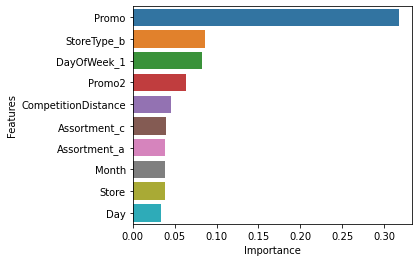

In [96]:
import seaborn as sns

plt.figure(figsize=(5,4))
sns.barplot(data=importance_df.head(10), x='Importance', y='Features')